# Taxon name information

## Input Name

Enter the taxon name. 

In [0]:
#@title String fields

taxonNameFull = 'Solanum baretiae' #@param {type:"string"}

taxonName = taxonNameFull.split(" ")

## Initialisation

### Importing Libraries

In [0]:
!pip install -q SPARQLWrapper
!pip install -q pykew

import requests
import json
import pandas as pd
from rdflib import *
from urllib.error import HTTPError

from google.colab import data_table
from IPython.display import display, Markdown, Latex, Image

import xml.etree.ElementTree as ET

from SPARQLWrapper import SPARQLWrapper, JSON

import warnings
warnings.filterwarnings('ignore') #suppress some warnings coming from RDFLib

import pykew.powo as powo
from pykew.powo_terms import Name
import pykew.ipni as ipni

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime



     |████████████████████████████████| 235kB 6.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [0]:
columns = ['scientificName', 'acceptedScientificName', 'recordedBy', 'year', 'eventDate', 'genus', 'species']
#columns = ['scientificName', 'acceptedScientificName']

### Defining the APIs

In [0]:
gbif_base_url = 'https://api.gbif.org/v1/'

gbif_occurence = gbif_base_url + 'occurrence/search'
gbif_species = gbif_base_url + 'species/match' # to retrieve the taxonKey

plazi_base_url = 'http://tb.plazi.org/GgServer/rdf/'


### Defining functions

In [0]:
def get_types(key,type_status):
  type_search = {'taxonKey' : key, 'typeStatus' : type_status, 'limit' : 20}

  type_request = requests.get(gbif_occurence, params=type_search)
  if type_request.status_code == 200:
    types = json.loads(type_request.text)
    endOfRecords = types['endOfRecords']
    df = pd.DataFrame(types['results'])
    iteration = 1
    while not endOfRecords:
      type_search = {'taxonKey' : key, 'typeStatus' : type_status, 'limit' : 20, 'offset' : iteration*20}
      type_request = requests.get(gbif_occurence, params=type_search)
      types = json.loads(type_request.text)
      endOfRecords = types['endOfRecords']
      dfe = pd.DataFrame(types['results'])
      df = df.append(dfe, ignore_index=True)
      iteration += 1
  else:
    print('Something went wrong')
  
  return df


## Get synonyms from POWO

In [0]:
p_query = {Name.genus : taxonName[0], Name.species : taxonName[1]}

name = []
synonyms = []

results = ipni.search(p_query)
spec = []
for r in results:
  if r['rank'] == 'spec.':
    spec.append(r)
  

for s in spec:
  powo_result = powo.lookup(s['fqId'])
  try:
    for synonym in powo_result['synonyms']:
      synonyms.append(synonym)
    for synonym in synonyms:
      print(synonym['name'])
  
  except KeyError:
    print('No synonyms found')




No synonyms found


## Get type specimen from GBIF

### Get the taxon key

In [0]:
taxonKey_search = {'name' : taxonNameFull, 'strict' : True, 'verbose' : True}

request = requests.get(gbif_species, params=taxonKey_search)
if request.status_code == 200:
  req_json = json.loads(request.text)
  if req_json['matchType'] == 'NONE':
    print('Species not found, try another one')
    assert(False)

  taxonKey = req_json['usageKey']
  speciesKey = req_json['speciesKey']
  genusKey = req_json['genusKey']
  genus = req_json['genus']
  species = req_json['species'].split(' ')[1]
else:
  print('Something went wrong, try different Scientific Name')
  assert(False)


### Look for type specimen in GBIF

List of Holotype
--------------------


,scientificName,acceptedScientificName,recordedBy,genus,species
0,Solanum baretiae Tepe,Solanum baretiae Tepe,"Sagastegui, A.",Solanum,Solanum baretiae


KeyError

 

List of Isotype
--------------------


,scientificName,acceptedScientificName,recordedBy,year,eventDate,genus,species
0,Solanum baretiae Tepe,Solanum baretiae Tepe,"Tepe, Eric. J., M R. McCarthy",2011.0,2011-07-31T00:00:00,Solanum,Solanum baretiae
1,Solanum baretiae Tepe,Solanum baretiae Tepe,"Sagastegui, A.",NaN,NaN,Solanum,Solanum baretiae
2,Solanum baretiae Tepe,Solanum baretiae Tepe,"Sagastegui, A.",NaN,NaN,Solanum,Solanum baretiae
3,Solanum baretiae Tepe,Solanum baretiae Tepe,"Sagastegui, A.",NaN,NaN,Solanum,Solanum baretiae


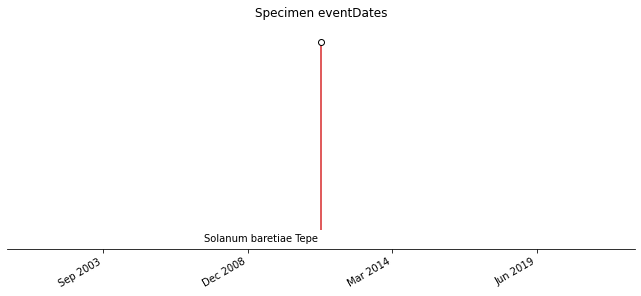


 

List of Paratype
--------------------
No Paratype found

 

List of Syntype
--------------------
No Syntype found

 

List of Lectotype
--------------------
No Lectotype found

 

List of Isolectotype
--------------------
No Isolectotype found

 

List of Neotype
--------------------
No Neotype found

 

List of Isoneotype
--------------------
No Isoneotype found

 

List of Epitype
--------------------
No Epitype found

 

List of Type
--------------------
No Type found

 



In [0]:
types_list = ['Holotype', 'Isotype', 'Paratype', 'Syntype', 'Lectotype', 'Isolectotype', 'Neotype', 'Isoneotype', 'Epitype', 'Type']

for type_name in types_list:
  print('List of ' + type_name)
  print('--------------------')
  types = get_types(taxonKey, type_name)
  if len(types) > 0:
    adjusted_columns = []
    for item in columns:
      if item in types.columns:
        adjusted_columns.append(item)
    types1 = types[adjusted_columns]
    display(data_table.DataTable(types1, include_index=False, num_rows_per_page=20))
  try:
    if len(types) > 0:
      #display(data_table.DataTable(types[columns], include_index=False, num_rows_per_page=20))
      # create a timeline
      # first drop the nan in eventdate
      types = types[types['eventDate'].notna()]

      names = types['scientificName'].tolist()
      dates = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in types.eventDate]
      # Choose some nice levels
      levels = np.tile([-5, 5, -3, 3, -1, 1],
                   int(np.ceil(len(dates)/6)))[:len(dates)]

      # Create figure and plot a stem plot with the date
      fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
      ax.set(title="Specimen eventDates")

      markerline, stemline, baseline = ax.stem(dates, levels,
                                           linefmt="C3-", basefmt="k-",
                                           use_line_collection=True)

      plt.setp(markerline, mec="k", mfc="w", zorder=3)

      # Shift the markers to the baseline by replacing the y-data by zeros.
      markerline.set_ydata(np.zeros(len(dates)))

      # annotate lines
      vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
      for d, l, r, va in zip(dates, levels, names, vert):
          ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                  textcoords="offset points", va=va, ha="right")

      # format xaxis with 62 month intervals
      ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=63))
      ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
      plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

      # remove y axis and spines
      ax.get_yaxis().set_visible(False)
      for spine in ["left", "top", "right"]:
          ax.spines[spine].set_visible(False)

      ax.margins(y=0.1)
      plt.show()
    else:
      print('No ' + type_name + ' found')
  except KeyError:
    print('KeyError')
    pass
  print('\n \n')

### Get taxonomic treatments

In [0]:
plazi_sparql = 'https://treatment.ld.plazi.org/sparql'

p_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dwc: <http://rs.tdwg.org/dwc/terms/>
PREFIX treat: <http://plazi.org/vocab/treatment#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
SELECT * WHERE {{ 
  ?tc dwc:genus "{0}" .
  ?tc dwc:species "{1}" .
  ?tc a <http://filteredpush.org/ontologies/oa/dwcFP#TaxonConcept> . 
  OPTIONAL {{ ?tc treat:hasTaxonName ?tn . }}
  OPTIONAL {{ ?augmentingTreatment treat:augmentsTaxonConcept ?tc . 
  ?augmentingTreatment dc:creator ?augmentingTreatmentCreator .}}
  OPTIONAL {{ ?definingTreatment treat:definesTaxonConcept ?tc . 
  ?definingTreatment dc:creator ?definingTreatmentCreator .}}
  }}
""".format(genus,species)

treatments = []

sparql = SPARQLWrapper(plazi_sparql)
sparql.setQuery(p_query)
sparql.setReturnFormat(JSON)

results = sparql.query().convert()


for result in results["results"]["bindings"]:
  try:
    treatments.append(result['definingTreatment']['value'])
  except KeyError:
    pass
  try:
    treatments.append(result['augmentingTreatment']['value'])
  except KeyError:
    pass

treatments = list(set(treatments))
print(treatments)



['http://treatment.plazi.org/id/A874B961396BBFC1940B74521C7C1402']
